# Методы нетренерованной сегментации изображений.

В данной ноутбуке разобраны несколько методов сегментации изображений, что значит разделение изображения на составные части, соответствующие различным предметам. 

1. Один из самых первых методов, метод роста областей. Требует от пользователя ввода разметки изображения, хотя бы по одному пикселю от каждого сегментируемого объекта. Далее построение областей происходит итеративно, для каждого пикселя, соседнего с уже размеченной областью, смотрится его расстоянии по яркости до средней яркости у области. Пиксель с минимальным расстоянием, не превышающим пороговое значение, добавляется к соответствующей области. В моем примере реазизации для генерации семян роста используется функция, схема работы которой примерно следующая - сначала изображение усредняется для удаления шумов, далее смотрятся значения яркости, превышающие пороговые, затем в каждой связной области смотрится точка, наиболее удаленная от краев области. Далее снова выбирается некоторая доля точек, которые принимаются за семена роста. Далее, оригинальный алгоритм должен каждый раз присоединять неклассифицированную точку с минимальным расстоянием яркости до группы. В моей версии реализован подход, когда все области растут одновременно. 

2. Сегментация методом водораздела. Основная идея состоит в том, что на изображении у одного объекта будут схожие характиристики, например яркость, текстура или цвет, а различные объекты в чем-то существенно отличаются. В геологии водораздел - условная топографическая линия на земной поверхности, разделяющая водосборы (бассейны) двух или нескольких рек, озёр, морей или океанов, направляя сток атмосферных осадков по двум противоположным склонам. 
    Для преобразования водораздела обычно рассматривают черно-белую версию изображения. Изображению топографическую карту, в которй каждому пикселю соответсвует абослютная величина градиента яркости изображения. 
    $$magnitude = \sqrt{ \left( \begin{bmatrix} 
-1 \\
0  \\
+1 
\end{bmatrix} * \mathbf{A}\right) ^ 2 + \left(\begin{bmatrix} 
-1 \\
0  \\
+1 
\end{bmatrix} ^ T * \mathbf{A}\right) ^ 2} $$
    Где $*$ означает свертку. Таким образом, как уже было сказано, у пикселей, принадлежащим одному объекту, яркость будет схожая, поэтому модуль градиента будет небольшим, тогда как на границе областей он будет большим. Тогда как раз границы областей и будут выступать водоразделами для объектов, областец с небольшим модулем градиента.
    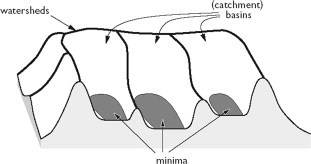
    После того, как построены границы, если в данных есть шум, или неудачно выбраны параметры процесса,  может получиться слишком много областей, тогда делается объединение областей, повышается "уровень воды", в следствие чего некоторые области объединяются, тем самым уменьшая уровень сегментации

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
img = cv2.imread('./samples/coins.jpg')
img = img[..., ::-1]

In [3]:
def compare(image, methode):
    img = image.copy()
    fig, axs = plt.subplots(1, 2, figsize=(20,10))
    axs[0].imshow(image)
    axs[1].imshow(methode(image))

In [4]:
def process_image_watercut(image):
    img = image.copy()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown==255] = 0
    markers = cv2.watershed(img,markers)
   
    return markers

In [5]:
def neighbors(mat, row, col, radius=1):
    neighbors = []
    for i in range(row - radius, row + radius + 1):
        for j in range(col - radius, col + radius + 1):
            neighbors.append((i, j))
    neighbors.remove((row, col))
    n_1 =  [item for item in neighbors if item[0]>=0 and item[0] < mat.shape[0] and item[1]>=0 and item[1] < mat.shape[1]]
    return n_1

def seed_finder(gray):
    kernel = np.ones((3,3),np.uint8)
    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)

    opening = cv2.morphologyEx(gray,cv2.MORPH_OPEN,kernel, iterations = 2)
    _, opening = cv2.threshold(opening,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    distances =  cv2.normalize(dist_transform, dist_transform, 0, 1.0, cv2.NORM_MINMAX)
    _, distances = cv2.threshold(distances, 0.90, 1.0, cv2.THRESH_BINARY)
    distances = np.uint8(distances)
    _, components = cv2.connectedComponents(distances)
    return components
    

def seed_segmentation_simultanious(image):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    components = seed_finder(gray)
    
    unique = np.unique(components)
    seeds = []
    for i in unique[1:]:
        seeds.append([np.where(components == i)[0][0], np.where(components == i)[1][0]])
        
    markers = components.copy()
    markers[markers == 0] = -1
    treshhold = 255 * .2
    changed = 0
    areas = list(range(1, np.max(markers)+10))
    markers_cash = markers.copy()
    for i in range(30):
        markers = markers_cash.copy()
        for i in range(len(areas)):
            areas[i] = np.mean(gray[markers == i])
        for row in range(markers.shape[0]):
            for column in range(markers.shape[1]):
                if markers[row, column] != -1:
                    neis = neighbors(markers, row, column)
                    for n in neis:
                        if markers[n] == -1:
                            if np.abs(gray[n] - areas[markers[row, column]]) < treshhold:
                                markers_cash[n] = markers[row, column]
                                changed += 1
                            
    
    markers[markers == -1] = 0
    return markers


C:\Users\sevag\Anaconda3\envs\mechamt\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\sevag\Anaconda3\envs\mechamt\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


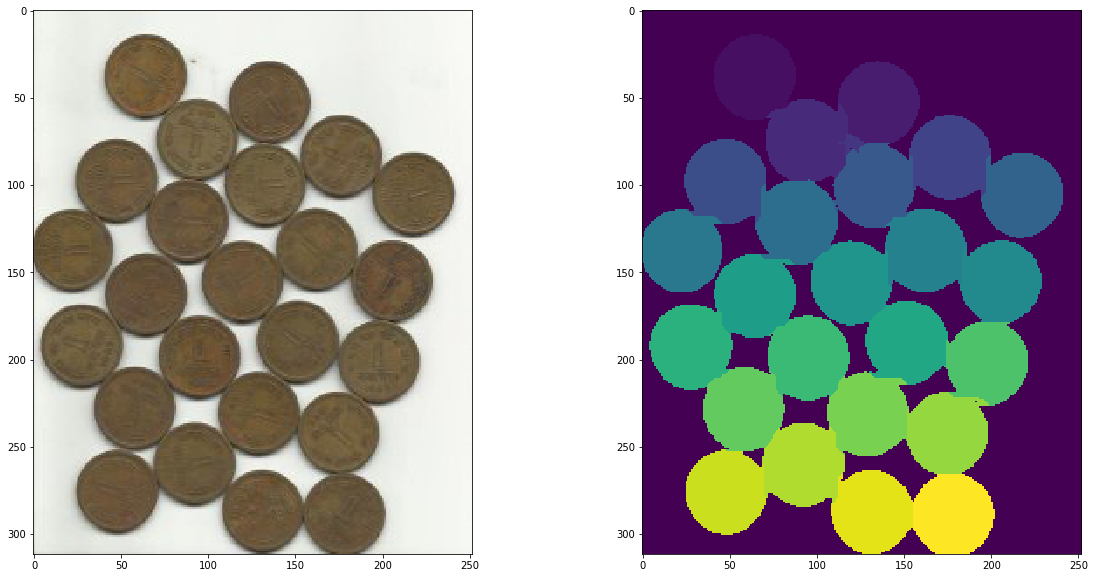

In [6]:
compare(img, seed_segmentation_simultanious)

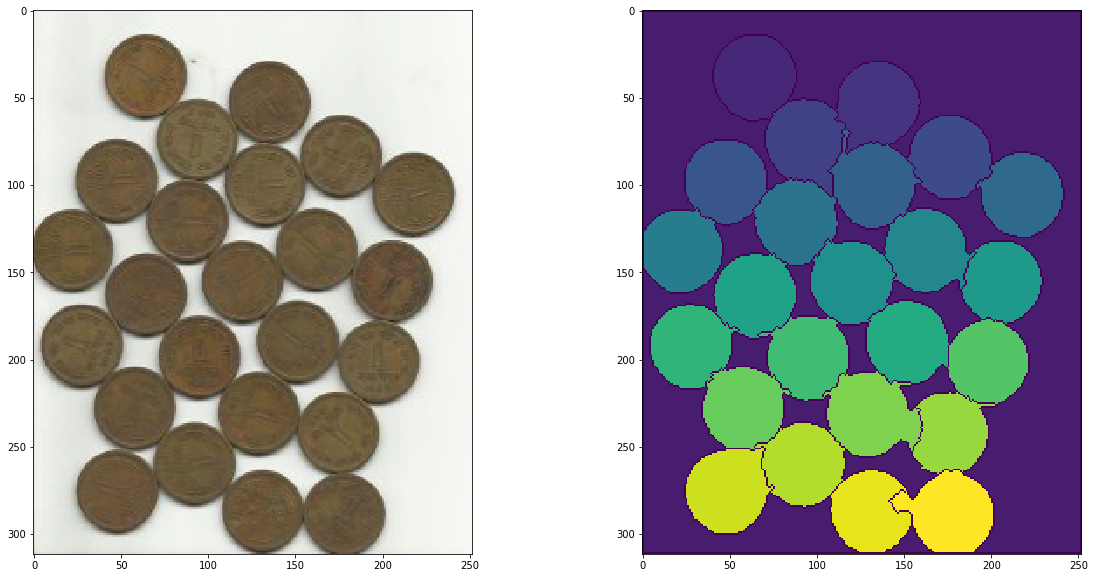

In [7]:
compare(img, process_image_watercut)